In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos


In [2]:
from pathlib import Path
import pickle
import pandas as pd
import jax
from jax import numpy as jnp
import numpy as np
from src.classical.classical_approach import load_data
from src.subsampling.subsample import fix_torus
from matplotlib import patches, pyplot as plt
from sklearn.decomposition import PCA
from src.plotting.plotting import *
from tqdm.notebook import tqdm

root_path = Path(".")
data_path = root_path / "data"
generated_data_path = root_path / "generated_data_extended"
plot_path = root_path / "plots"

points_array, velocities_array, indices, halo_props = pickle.load(open(generated_data_path / "example_halos.pkl", 'rb'))
subsampled = jnp.load(generated_data_path / "kmeans_subsampled_n1_s75.npz")

In [36]:
list(points_array.keys())

[9, 10, 11, 12, 13]

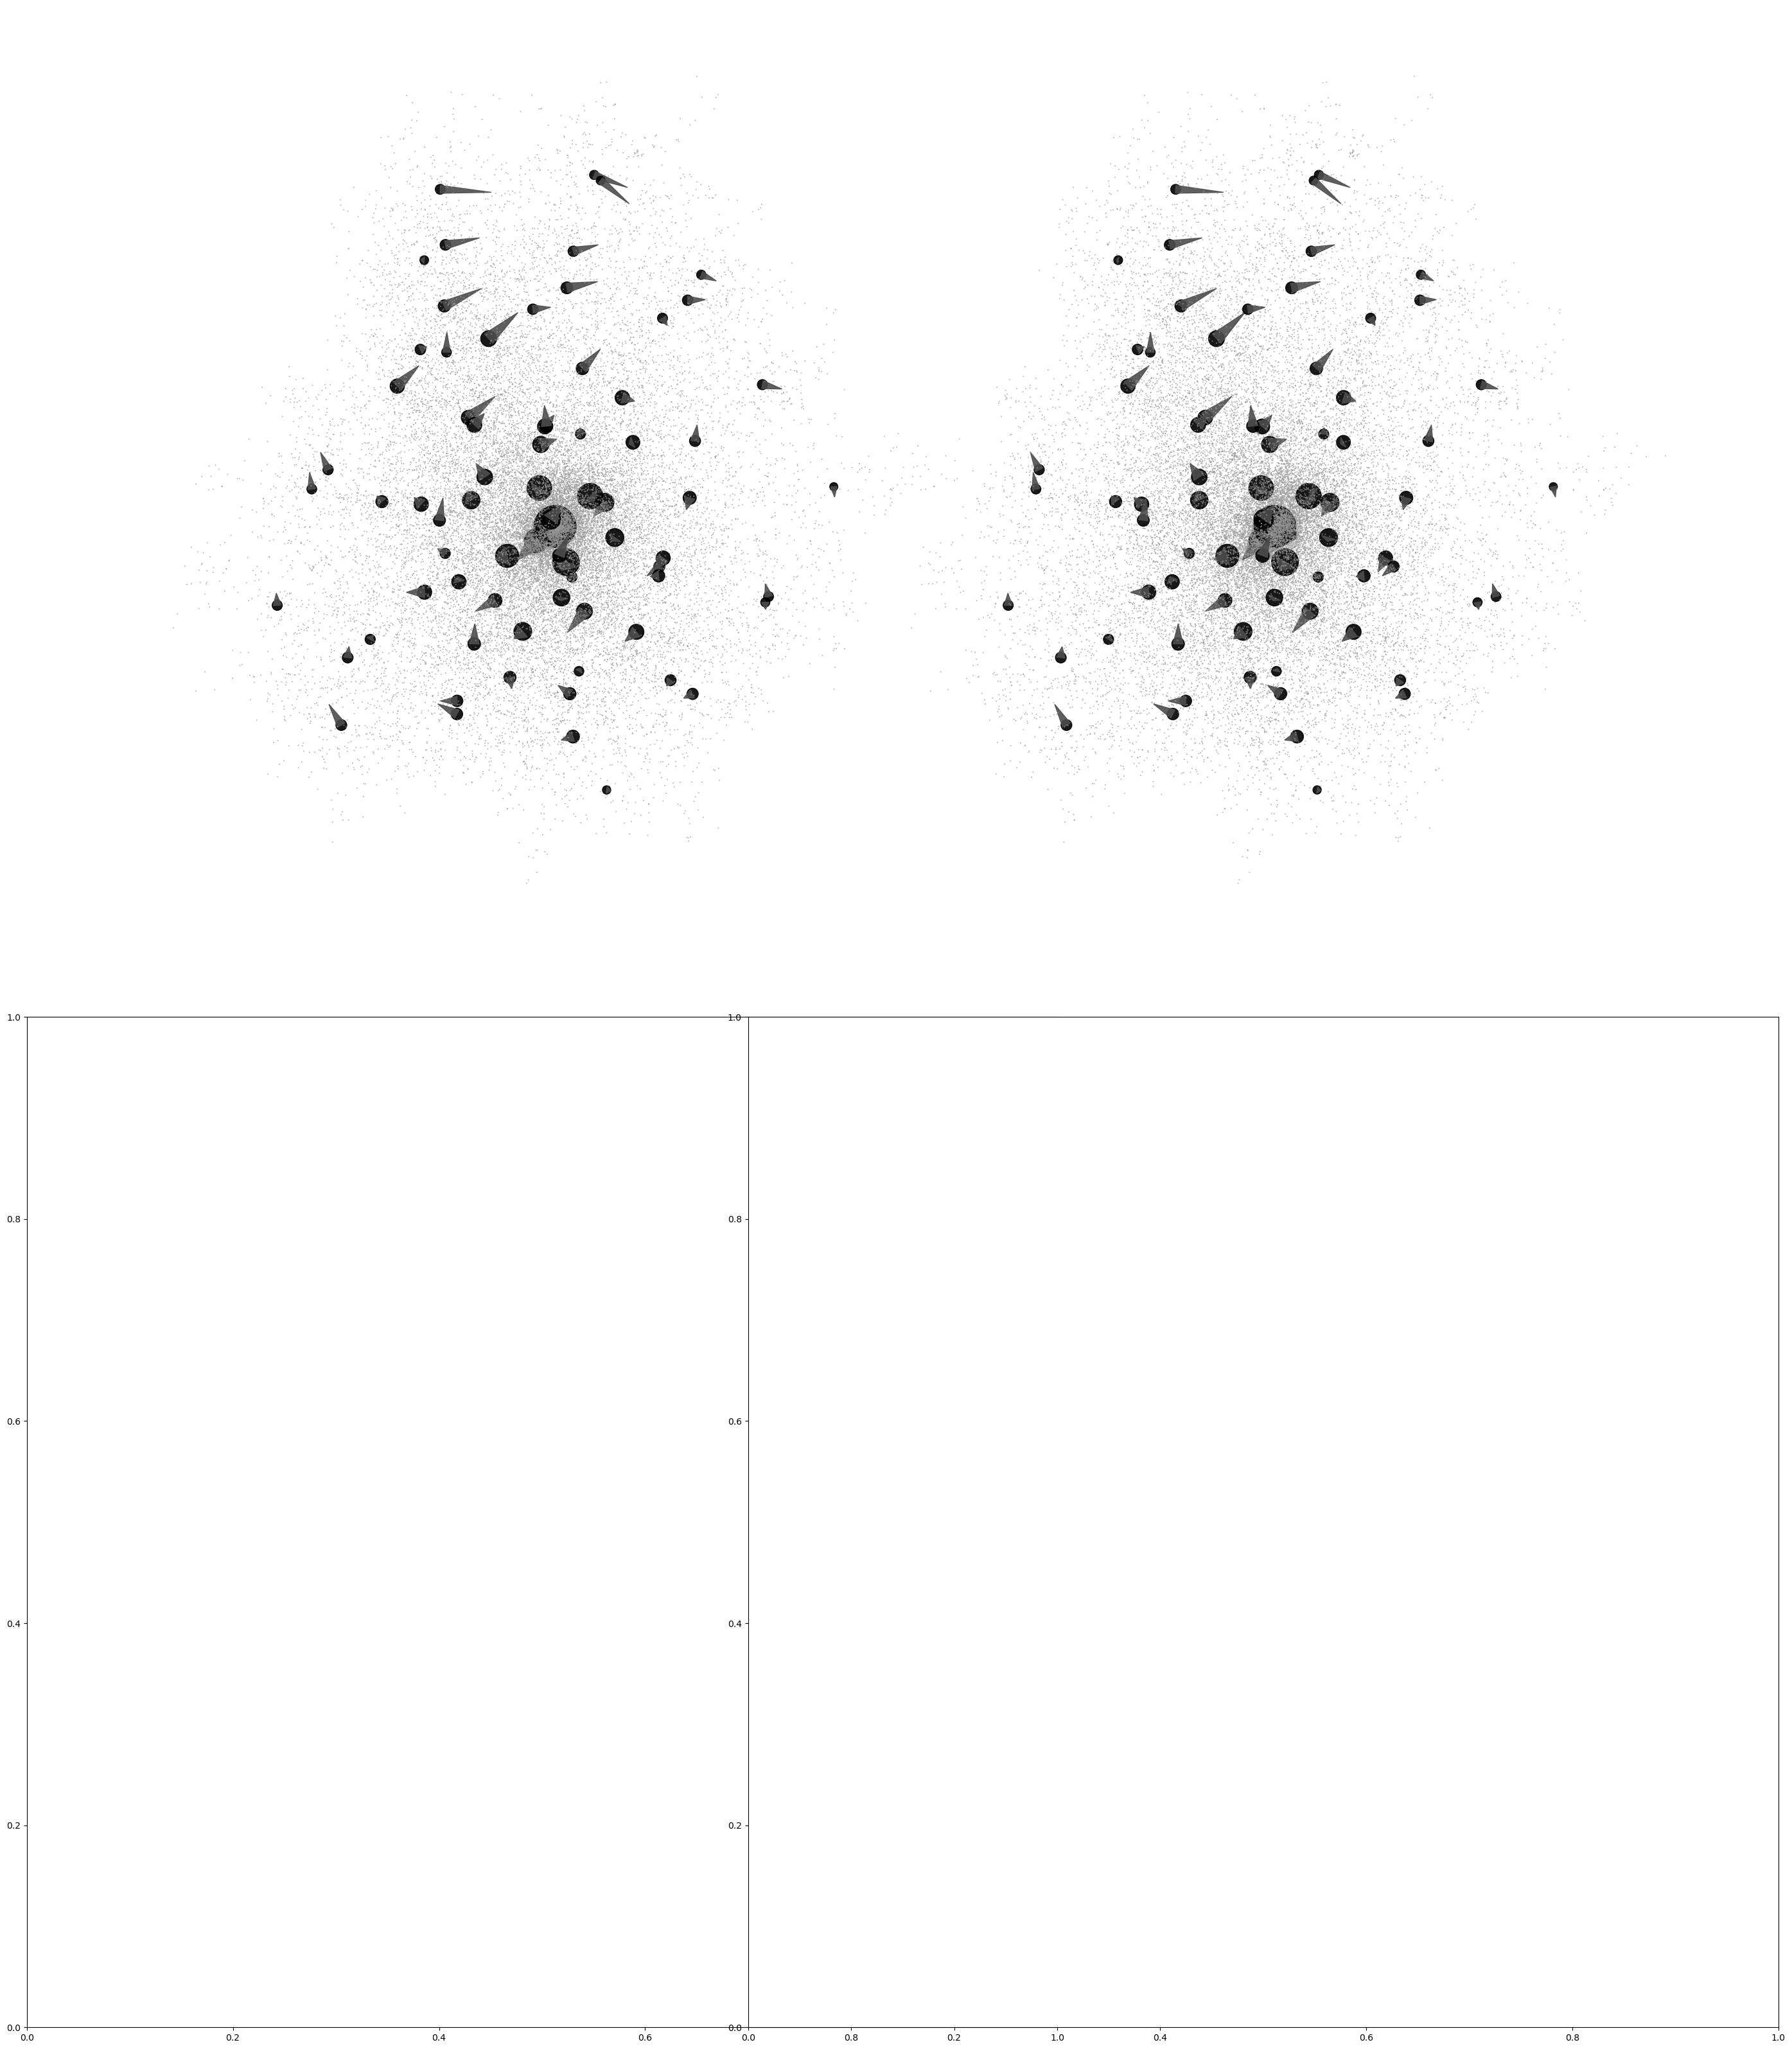

In [31]:
scale = 10
t = 0
ix = indices[scale][0]
points = fix_torus(points_array[scale][0])
velocities = velocities_array[scale][0]
points_subsampled = subsampled["points"][ix, t]
weights_subsampled = subsampled["weights"][ix, t]
velocities_subsampled = subsampled["velocities"][ix, t]

n_frames = 100
rotation_per_frame = 2 * jnp.pi / n_frames


n_rows = 2
n_cols = 1
angle = 0
theta = 0.1

n_rows = 6


fig, axs = plt.subplots(n_rows, 2, figsize=(28, 16 * n_rows))

plotting_kwargs = {"scale_with_z_order": False, "rel_size" : 4}
def plot_stereo(i: int):
    plot_from_above_perturbed(
        angle,
        points,
        velocities,
        points_subsampled,
        velocities_subsampled,
        weights_subsampled,
        axs[i, 0],
        **plotting_kwargs,
    )
    plot_from_above_perturbed(
        angle + theta,
        points,
        velocities,
        points_subsampled,
        velocities_subsampled,
        weights_subsampled,
        axs[i, 1],
        **plotting_kwargs,
    )

plot_stereo(0)
plt.tight_layout()
fig.subplots_adjust(wspace=-0.3, hspace=0)
# plot_from_above_perturbed(
#     0.0,
#     np.array(points),
#     np.array(velocities),
#     np.array(points_subsampled),
#     np.array(velocities_subsampled),
#     np.array(weights_subsampled),
#     ax,
#     rel_size=1.
# )

# folder = "stereograph_gif_frames_2"
# os.mkdir(plot_path / folder)
# for i in tqdm(range(n_frames)):
#     plot_save_stereogram(
#         i * rotation_per_frame,
#         0.1,
#         points,
#         velocities,
#         points_subsampled,
#         velocities_subsampled,
#         weights_subsampled,
#         fname=plot_path / folder / f"stereo_{str(i).zfill(3)}.png"
#     )
#     plt.close()

In [13]:
ax.get_xlim()

NameError: name 'ax' is not defined